$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Assignment 5: Neural Networks

*Ben Newell*

## Overview

You will write and apply code that trains neural networks of various numbers of hidden layers and units in each hidden layer and returns results as specified below.  You will do this once for a regression problem and once for a classification problem. 

## Required Code

Download [nn2.tar](http://www.cs.colostate.edu/~anderson/cs440/notebooks/nn2.tar) that was used in lecture and extract its contents, which are

* `neuralnetworks.py`
* `scaledconjugategradient.py`
* `mlutils.py`

Write the following functions that train and evaluate neural network models.

* `results = trainNNs(X, T, trainFraction, hiddenLayerStructures, numberRepetitions, numberIterations, classify)`

The arguments to `trainNNs` are

* `X` is a matrix of input data of shape `nSamples x nFeatures`
* `T` is a matrix of target data of shape `nSamples x nOutputs`
* `trainFraction` is fraction of samples to use as training data. 1-`trainFraction` is number of samples for testing data
* `hiddenLayerStructures` is list of network architectures. For example, to test two networks, one with one hidden layer of 20 units, and one with 3 hidden layers with 5, 10, and 20 units in each layer, this argument would be `[[20], [5, 10, 20]]`.
* `numberRepetitions` is number of times to train a neural network.  Calculate training and testing average performance (two separate averages) of this many training runs.
* `numberIterations` is the number of iterations to run the scaled conjugate gradient algorithm when a neural network is trained.
* `classify` is set to `True` if you are doing a classification problem, in which case `T` must be a single column of target class integers.

This function returns `results` which is list with one element for each network structure tested.  Each element is a list containing 

* the hidden layer structure (as a list),
* a list of training data performance for each repetition, 
* a list of testing data performance for each repetition, and
* the number of seconds it took to run this many repetitions for this network structure.

This function should follow these steps:

  * For each network structure given in `hiddenLayerStructures`
    * For numberRepetitions
      * Use `ml.partition` to randomly partition X and T into training and testing sets.
      * Create a neural network of the given structure
      * Train it for numberIterations
      * Use the trained network to produce outputs for the training and for the testing sets
      * If classifying, calculate the fraction of samples incorrectly classified for training and testing sets.
       Otherwise, calculate the RMSE of training and testing sets.
      * Add the training and testing performance to a collection (such as a list) for this network structure
    * Add to a collection of all results the hidden layer structure, lists of training performance and testing performance, and seconds taken to do these repetitions.
  * return the collection of all results

Also write the following two functions. `summarize(results)` returns a list of lists like `results` but with the list of training performances replaced by their mean and the list of testing performances replaced by their mean.   
`bestNetwork(summary)` takes the output of `summarize(results)` and returns the best element of `results`, determined by the element that has the smallest test performance.

* `summary = summarize(results)` where `results` is returned by `trainNNs` and `summary` is like `results` with the training and testing performance lists replaced by their means
* `best = bestNetwork(summary)` where `summary` is returned by `summarize` and `best` is the best element of `summary`

Here are the imports from the supplied code. 

In [1]:
import neuralnetworks as nn
import scaledconjugategradient as scg
import mlutils as ml
import time


In [186]:
def trainNNs(X, Y, trainFraction, hiddenLayerStructures, numberRepetitions,
             numberIterations, classify = False, residuals = False):
    #In statistics and in the neural net code, the "target" matrix is Y
    #I'm more used to this.
    results = []
    start = time.time()
    for structure in hiddenLayerStructures:
        trainedList = []
        testedList = []
        for _ in range(numberRepetitions):
            #Unsure about what the validation return does.
            Xtrain,Ytrain,Xtest,Ytest = ml.partition(X, Y, 
                                        (trainFraction, 1 - trainFraction), False)
            #create nn with the right structure.
            #initiallizes ni->columns of X
            #             no->columns of Y
            #             nhs->our given structure in hidden layers
            if not classify:
                nnet = nn.NeuralNetwork(X.shape[1], structure, Y.shape[1])
            else:
                nnet = nn.NeuralNetworkClassifier(X.shape[1],structure, np.unique(Y))
            #Train for number of iterations.
            nnet.train(Xtrain, Ytrain, numberIterations)
            #collect the trained outputs with training data and test data
            predictedYTrained = nnet.use(Xtrain)
            predictedYTested = nnet.use(Xtest)
            #calculate the mean standard error for these dudes.
            # VVVVVVVV THE BELOW IS FOR SIGMA SQUARED, DATA ITSELF
            # not the statistically correct way of doing it, need n - estimated paramaters df.
            # so for simple regression n -2 df, = number of columns in X with column of ones.
            #Difference between measuring the amount of error and trying to estimate
            #Epsilons in the model.
            if not classify:
                rmseTrained = np.sqrt(np.mean((Ytrain - predictedYTrained) ** 2))
                rmseTested = np.sqrt(np.mean((Ytest - predictedYTested) ** 2))
            else:
                rmseTrained = 1
                rmseTested = 1
            #could also save the residuals here and talk about trends...
            trainedList.append(rmseTrained)
            testedList.append(rmseTested)
        end = time.time()
        results.append([structure, trainedList, testedList, end - start])
        if residuals:
            results.append([Ytrain - predictedYTrained, Ytest - predictedYTested])            
    return results

In [3]:
def linearRegression(X,Y):
    newX = np.c_[np.ones(len(X)), X] #Adds a column of ones to the beginning for intercept.
    #This finds the OLS estimator for the model
    #beta = (XtX)-1XtY. Thanks cooley!
    betas = np.linalg.inv((np.transpose(newX) @ newX)) @ np.transpose(newX) @ Y
    # our prediction will the be Xo @ beta.
    predictedYs = newX @ betas
    rmse = np.sqrt(np.mean((predictedYs - Y) ** 2))
    #not sdhat     |msres~~~~~~~~~~~~~~~~~~~~~~~~~| <- actually not, should be adjusted for df.
    return rmse, betas

In [4]:
def summarize(results):
    summarized = list(range(len(results)))
    for t in range(len(results)):
        summarized[t] = [results[t][0], np.mean(results[t][1]), np.mean(results[t][2]), results[t][3]]
    return summarized

In [5]:
def bestNetwork(summary):
    lowestError = float('inf')
    lowestNetwork = summary[0]
    for s in summary:
        if s[2] < lowestError:
            lowestError = s[2]
            lowestNetwork = s
        
    return lowestNetwork

## Examples


In [6]:
import neuralnetworks as nn
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
X = np.arange(10).reshape((-1,1))
T = X + 1 + np.random.uniform(-1, 1, ((10,1)))

In [8]:
Xtrain,Train, Xtest,Ttest =ml.partition(X, T, (0.7, 0.3), False)

In [9]:
X

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8],
       [9]])

In [10]:
print(Xtrain)
print(Train)
print(Xtest)
print(Ttest)
print(X)
print(T)

[[7]
 [2]
 [0]
 [3]
 [5]
 [4]
 [6]]
[[8.74542136]
 [3.10953491]
 [0.39850704]
 [4.55996697]
 [5.54966612]
 [5.80801425]
 [7.56440969]]
[[9]
 [1]
 [8]]
[[9.32423005]
 [1.04504362]
 [8.95416261]]
[[0]
 [1]
 [2]
 [3]
 [4]
 [5]
 [6]
 [7]
 [8]
 [9]]
[[0.39850704]
 [1.04504362]
 [3.10953491]
 [4.55996697]
 [5.80801425]
 [5.54966612]
 [7.56440969]
 [8.74542136]
 [8.95416261]
 [9.32423005]]


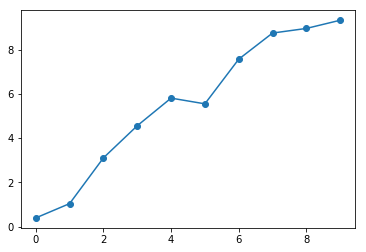

In [11]:
plt.plot(X, T, 'o-');

In [12]:
nnet = nn.NeuralNetwork(X.shape[1], 2, T.shape[1])
nnet.train(X, T, 100)
nnet.getErrorTrace()

array([0.70710678, 0.43862362, 0.3425817 , 0.13747625, 0.13299411,
       0.12859982, 0.11963952, 0.11504797, 0.10644153, 0.10602395,
       0.1045919 , 0.10369067, 0.10148475, 0.10121311, 0.10013632,
       0.09982874, 0.09961846, 0.09915182, 0.09913596, 0.09906389,
       0.09896772, 0.09894133, 0.09892057, 0.09871251, 0.09850515,
       0.09848379, 0.09848025, 0.09840947, 0.09839429, 0.0983896 ,
       0.09828602, 0.09823573, 0.09822272, 0.09821681, 0.09820758,
       0.09820154, 0.09819794, 0.09801991, 0.09793459, 0.09774999,
       0.09762193, 0.097616  , 0.09758438, 0.09758124, 0.09758084,
       0.09757246, 0.09757246, 0.09757246, 0.09757246, 0.09757246,
       0.09757246, 0.09757246, 0.09757246, 0.09757246, 0.09757246,
       0.09757246, 0.09757246, 0.09757246, 0.09757246, 0.09757246,
       0.09757246, 0.09757246, 0.09757246, 0.09757246, 0.09757246,
       0.09757246, 0.09751083, 0.09751063, 0.09741442, 0.0974019 ,
       0.09740023, 0.09739518, 0.09738879, 0.09738879, 0.09738

In [13]:
nnet = nn.NeuralNetwork(X.shape[1], [5, 5, 5], T.shape[1])
nnet.train(X, T, 100)
nnet.getErrorTrace()

array([0.70710678, 0.54449559, 0.54449559, 0.35576002, 0.22372376,
       0.11681007, 0.11247585, 0.10948867, 0.10734977, 0.10002508,
       0.09994666, 0.09992661, 0.09868339, 0.09852363, 0.09787777,
       0.0977235 , 0.09769168, 0.09729695, 0.09726334, 0.09724384,
       0.09721027, 0.09707753, 0.09667482, 0.09642693, 0.09610857,
       0.09609212, 0.09595421, 0.09594943, 0.0959433 , 0.0959433 ,
       0.0959433 , 0.0959433 , 0.0959433 , 0.0959433 , 0.0959433 ,
       0.0959433 , 0.0959433 , 0.0959433 , 0.0959433 , 0.09519702,
       0.09511498, 0.09490296, 0.09466886, 0.09454314, 0.09443275,
       0.09438759, 0.09433795, 0.09428921, 0.09338813, 0.09140835,
       0.09000754, 0.09000754, 0.09000754, 0.09000754, 0.09000754,
       0.09000754, 0.08758447, 0.08749536, 0.07237127, 0.06924245,
       0.06757119, 0.06369509, 0.06264829, 0.05925818, 0.05906436,
       0.05548299, 0.05475893, 0.0539506 , 0.0538459 , 0.05339817,
       0.05332376, 0.05325291, 0.05188459, 0.05104863, 0.05026

In [14]:
results = trainNNs(X, T, 0.8, [2, 10, [10, 10]], 5, 100, classify=False)
results

[[2,
  [0.11778694123062598,
   0.297508747311452,
   0.4138350942314038,
   0.36908431593801816,
   0.09914591067739921],
  [0.9040409022765081,
   0.3881232036849132,
   0.5220628912144669,
   0.6689080068979316,
   0.8507625339340881],
  0.20973730087280273],
 [10,
  [0.15214360186743728,
   0.19514537168688398,
   0.17204669507811804,
   0.15159099197193604,
   0.16412497938003798],
  [0.6956598226150906,
   0.5443240688125266,
   0.5238512027499446,
   1.221330146620304,
   0.5639996957535496],
  0.28496503829956055],
 [[10, 10],
  [0.175709941426887,
   0.14442595811926862,
   0.26330849866277234,
   0.33971901634314816,
   0.15601010818966057],
  [0.8386421642732219,
   1.0426095626291172,
   1.3603809576824881,
   0.3838387328227119,
   0.8998070882867675],
  0.4009077548980713]]

In [143]:
results = trainNNs(X, T, 0.8, [0, 1, 2, 10, [10, 10], [5, 5, 5, 5], [2]*5], 50, 100, classify=False)

In [144]:
summarize(results)

[[0, 0.576124213000935, 0.7474026334076649, 0.029050588607788086],
 [1, 0.4029615288194854, 0.5589110651481498, 0.7961351871490479],
 [2, 0.300212203090692, 0.824541333939657, 1.5188696384429932],
 [10, 0.15143259161785166, 0.6560805598245288, 2.476900815963745],
 [[10, 10], 0.13722919795265295, 0.7005216464169826, 3.6821534633636475],
 [[5, 5, 5, 5], 0.2706298148093324, 0.7285008291353334, 5.289577960968018],
 [[2, 2, 2, 2, 2], 0.3518584218989902, 0.6529362540919734, 6.961448907852173]]

In [17]:
model = linearRegression(X, T)

Here we print out the model, which takes the form of RMSE, array of betas (Weights)

In [18]:
model

(0.6009334745609894, array([[0.79781151],
        [1.04624092]]))

Linear regression plot of model versus line

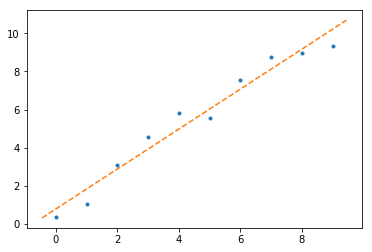

In [19]:
def abline(slope, intercept):
    #borrowed from: 
    #https://stackoverflow.com/questions/7941226/how-to-add-line-based-on-slope-and-intercept-in-matplotlib
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

plt.plot(X, T, ".")
abline(model[1][1], model[1][0])

In [20]:
best = bestNetwork(summarize(results))
print(best)
print('Hidden Layers {} Average RMSE Training {:.2f} Testing {:.2f} Took {:.2f} seconds'.format(*best))

[1, 0.4071626594823395, 0.5721258898474021, 0.7957806587219238]
Hidden Layers 1 Average RMSE Training 0.41 Testing 0.57 Took 0.80 seconds


Hummm...neural nets with no hidden layers did best on this simple data set.  Why?  Remember what "best" means.

Because its a linear trend!

## Data for Regression Experiment

From the UCI Machine Learning Repository, download the [Appliances energy prediction](http://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction) data.  You can do this by visiting the Data Folder for this data set, or just do this:

     !wget http://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv



Read this data into python.  One suggestion is to use the `loadtxt` function in the `numpy` package.  You may ignore the first column of each row which contains a data and time.  Also ignore the last two columns of random variables.  We will not use that in our modeling of this data.  You will also have to deal with the double quotes that surround every value in every field.  Read the first line of this file to get the names of the features.

Once you have read this in correctly, you should see values like this:

CSV reading

In [21]:
import pandas as pd
csv = pd.read_csv("energydata_complete.csv")
#drop unneeded columns
csv = csv.drop(['date', 'rv1', 'rv2'], axis = 1)

In [22]:
#names
csv.columns

Index(['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint'],
      dtype='object')

In [23]:
data = csv.values #.values is a numpy array! 
data.shape

(19735, 26)

In [24]:
data


array([[ 60.        ,  30.        ,  19.89      , ...,   7.        ,
         63.        ,   5.3       ],
       [ 60.        ,  30.        ,  19.89      , ...,   6.66666667,
         59.16666667,   5.2       ],
       [ 50.        ,  30.        ,  19.89      , ...,   6.33333333,
         55.33333333,   5.1       ],
       ...,
       [270.        ,  10.        ,  25.5       , ...,   3.66666667,
         25.33333333,  13.26666667],
       [420.        ,  10.        ,  25.5       , ...,   3.83333333,
         26.16666667,  13.23333333],
       [430.        ,  10.        ,  25.5       , ...,   4.        ,
         27.        ,  13.2       ]])

In [25]:
data[:2,:]

array([[ 60.        ,  30.        ,  19.89      ,  47.59666667,
         19.2       ,  44.79      ,  19.79      ,  44.73      ,
         19.        ,  45.56666667,  17.16666667,  55.2       ,
          7.02666667,  84.25666667,  17.2       ,  41.62666667,
         18.2       ,  48.9       ,  17.03333333,  45.53      ,
          6.6       , 733.5       ,  92.        ,   7.        ,
         63.        ,   5.3       ],
       [ 60.        ,  30.        ,  19.89      ,  46.69333333,
         19.2       ,  44.7225    ,  19.79      ,  44.79      ,
         19.        ,  45.9925    ,  17.16666667,  55.2       ,
          6.83333333,  84.06333333,  17.2       ,  41.56      ,
         18.2       ,  48.86333333,  17.06666667,  45.56      ,
          6.48333333, 733.6       ,  92.        ,   6.66666667,
         59.16666667,   5.2       ]])

Use the first two columns, labelled `Appliances` and `lights` as the target variables, and the remaining 24 columns as the input features.  So

In [26]:
Tenergy = data[:, :2]
Xenergy = data[:, 2:]

In [197]:
type(Xenergy[1])

numpy.ndarray

In [27]:
Xenergy.shape, Tenergy.shape

((19735, 24), (19735, 2))

If you were stuck on a desert island with a raspberry pi, this might be the fastest way to go. 

In [28]:
mod = linearRegression(Xenergy, Tenergy)

In [29]:
mod

(67.16000985310131, array([[ 3.46616558e+01, -7.43996489e+00],
        [ 3.87404950e-01,  4.99478315e-01],
        [ 1.60676718e+01,  4.60447964e-01],
        [-2.03023792e+01, -1.30706445e+00],
        [-1.44106352e+01, -4.68988706e-01],
        [ 2.53782507e+01, -1.58894399e-02],
        [ 5.04805794e+00,  6.24637873e-02],
        [ 2.97566214e+00,  3.23981594e+00],
        [ 1.94699006e+00,  1.06951427e+00],
        [-1.10836980e-02,  3.85602776e-03],
        [ 2.39073626e-01,  4.88359182e-02],
        [ 7.66167382e+00,  2.68051223e-01],
        [ 3.47156267e-01,  2.98243731e-02],
        [ 1.13054583e+00, -3.34818514e-01],
        [-1.84314955e+00, -1.46848016e-01],
        [ 1.01537621e+01,  1.00751733e+00],
        [-5.90648932e+00, -6.20613175e-01],
        [-2.21080671e+01, -3.12484426e+00],
        [-1.50004806e+00, -3.03505238e-01],
        [-1.06453244e+01, -2.07106041e-01],
        [ 1.23031901e-01, -8.36014286e-03],
        [-9.12029514e-01,  7.70472294e-02],
        [ 2.1

Train several neural networks on all of this data for 100 iterations.  Plot the error trace (nnet.getErrorTrace()) to help you decide now many iterations might be needed.  100 may not be enough.  If for your larger networks the error is still decreasing after 100 iterations you should train all nets for more than 100 iterations.

Now use your `trainNNs`, `summarize`, and `bestNetwork` functions on this data to investigate various network sizes.

In [30]:
results = trainNNs(Xenergy, Tenergy, 0.8, [0, 5, [5, 5], [10, 10]], 10, 100)

In [31]:
summarize(results)

[[0, 67.11932368747621, 67.35359008195059, 0.9704840183258057],
 [5, 65.16329727013253, 66.09507981020042, 13.485072612762451],
 [[5, 5], 64.74445779866605, 65.25715213150605, 28.255380630493164],
 [[10, 10], 63.090387388750834, 64.22953948206502, 46.76314687728882]]

In [32]:
bestNetwork(summarize(results))

[[10, 10], 63.090387388750834, 64.22953948206502, 46.76314687728882]

Here, plot the residuals of the best versus the residuals of the linear regression to see what sort of trend neural net might have picked up. 

Test at least 10 different hidden layer structures.  Larger numbers of layers and units may do the best on training data, but not on testing data. Why?

Now train another network with your best hidden layer structure on 0.8 of the data and use the trained network on the testing data (the remaining 0.2 of the date).  As before use `ml.partition` to produce the training and testing sets.

For the testing data, plot the predicted and actual `Appliances` energy use, and the predicted and actual `lights` energy use, in two separate plots.  Discuss what you see.

Create new nn with .8 for training and .2 for testing. Best was 10,10

In [42]:
results = trainNNs(Xenergy, Tenergy, 0.8, [[1,1,1,1,1,1], [5, 5, 5], [20, 20], [10, 10, 10, 10],[100]], 10, 100)

In [44]:
restultsPlus = results = trainNNs(Xenergy, Tenergy, 0.8, [[100, 100, 100], [20,20,20,20,20], [1000]], 10, 100)

In [43]:
summarize(results)

[[[1, 1, 1, 1, 1, 1], 71.79997644053165, 72.29999061219522, 9.39830493927002],
 [[5, 5, 5], 64.91141428899094, 65.7830692206122, 24.009613513946533],
 [[20, 20], 61.90068739386489, 64.04824036001659, 47.157387256622314],
 [[10, 10, 10, 10], 63.51466505543108, 64.77065328336718, 69.93183708190918],
 [[100], 61.50856145643676, 62.792612191632735, 152.19349813461304]]

In [46]:
summarize(restultsPlus)

[[[100, 100, 100], 61.964421750705114, 64.60583068983202, 232.16375517845154],
 [[20, 20, 20, 20, 20],
  62.59309809195922,
  63.850184944615705,
  285.5029180049896],
 [[1000], 61.780180856355834, 62.2625238614339, 1135.4064993858337]]

In [33]:
#Create and train the nn.
#Do this with 1000, but maybe on your desktop.
bestNN = nn.NeuralNetwork(Xenergy.shape[1], [10,10], Tenergy.shape[1])
Xtrain,Ytrain,Xtest,Ytest=ml.partition(Xenergy, Tenergy, (.8, .2), False)
bestNN.train(Xtrain, Ytrain, 1000) #300 should be fine
#Final error is not the same as RMSE


NeuralNetwork(24, [10, 10], 2)
   Network was trained for 1001 iterations. Final error is 0.5365813109798514.

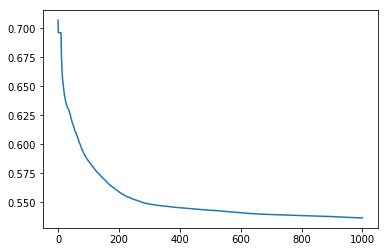

In [34]:
plt.plot(bestNN.getErrorTrace())

In [35]:
Ypredicted = bestNN.use(Xenergy)

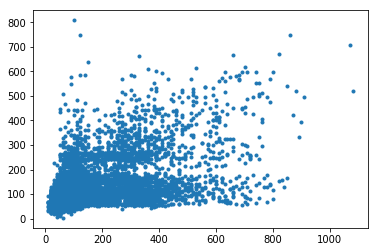

In [36]:
plt.plot(Tenergy[:,0], Ypredicted[:,0], ".")

Here is a plot of actual vs predicted. Really doesn't look great in terms of predictive power

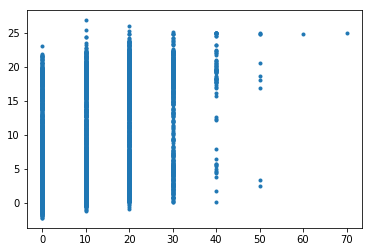

In [37]:
plt.plot(Tenergy[:,1], Ypredicted[:,1], ".")

In [38]:
np.unique(Tenergy[:,1])

array([ 0., 10., 20., 30., 40., 50., 60., 70.])

Here it is for the other one, not appliance maybe?

Here are some plots of residuals!

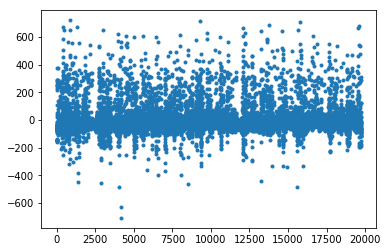

In [39]:
plt.plot(Tenergy[:,0] - Ypredicted[:,0], ".")

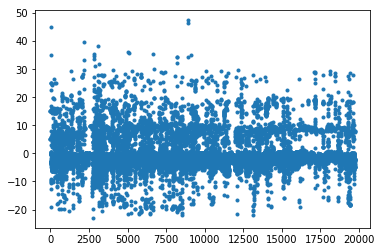

In [40]:
plt.plot(Tenergy[:,1] - Ypredicted[:,1], ".")

## Data for Classification Experiment

From the UCI Machine Learning Repository, download the [Anuran Calls (MFCCs)](http://archive.ics.uci.edu/ml/datasets/Anuran+Calls+%28MFCCs%29) data.  You can do this by visiting the Data Folder for this data set, or just do this:

     !wget 'http://archive.ics.uci.edu/ml/machine-learning-databases/00406/Anuran Calls (MFCCs).zip'
     !unzip Anuran*zip
     
Read the data in the file `Frogs_MFCCs.csv` into python.  This will be a little tricky. Each line of the file is a sample of audio features plus three columns that label the sample by family, genus, and species. We will try to predict the species.  The tricky part is that the species is given as text.  We need to convert this to a target class, as an integer. The `numpy` function `unique` will come in handy here.

In [154]:
csv = pd.read_csv("Frogs_MFCCs.csv")
csv = csv.drop(['RecordID', 'Family', 'Genus', 'MFCCs_ 1'], axis = 1) #also drops MFCCs_1, 
                                                                    #which only has the value 1, no in his.

In [190]:
csv.shape

(7195, 22)

In [206]:
data = csv.values
Tanuran = data[:, 21:]
Xanuran = data[:, :21]
Xanuran = Xanuran.astype(np.float64)
#print(type(Xanuran[1,1]))
#print(Xanuran.astype(np.float64))
#print(type(Xenergy[1,1]))

In [207]:
Xanuran.shape, Tanuran.shape

((7195, 21), (7195, 1))

In [208]:
Xanuran[:2,:]

array([[ 0.1529363 , -0.1055859 ,  0.20072191,  0.31720106,  0.26076385,
         0.10094464, -0.1500626 , -0.17112763,  0.12467644,  0.18865415,
        -0.07562172, -0.15643593,  0.08224512,  0.13575204, -0.02401665,
        -0.10835111, -0.07762252, -0.0095678 ,  0.05768398,  0.11868014,
         0.01403845],
       [ 0.17153426, -0.09897474,  0.26842522,  0.33867186,  0.2683531 ,
         0.06083509, -0.22247464, -0.20769267,  0.17088287,  0.27095828,
        -0.09500394, -0.25434147,  0.02278623,  0.1633201 ,  0.01202228,
        -0.09097401, -0.05650952, -0.03530336,  0.02013996,  0.08226299,
         0.02905574]])

In [209]:
names = np.unique(Tanuran)
names = list(names)
for i in range(len(Tanuran)):
    Tanuran[i] = names.index(Tanuran[i])
#Tanuran = [names.index(n) for n in Tanuran]
#Tanuran = [[x] for x in Tanuran]
#Tanuran = np.array(Tanuran)

In [214]:
Tanuran = Tanuran.astype(int)
Tanuran[:2]

array([[0],
       [0]])

In [215]:
for i in range(10):
    print('{} samples in class {}'.format(np.sum(Tanuran==i), i))

672 samples in class 0
3478 samples in class 1
542 samples in class 2
310 samples in class 3
472 samples in class 4
1121 samples in class 5
270 samples in class 6
114 samples in class 7
68 samples in class 8
148 samples in class 9


In [216]:
results = trainNNs(Xanuran, Tanuran, 0.8, [0, 5, [5, 5]], 5, 100, classify=True)

TypeError: only integer scalar arrays can be converted to a scalar index

In [26]:
summarize(results)

[[0, 0.028179291174426684, 0.034885337039610845, 2.706338405609131],
 [5, 0.035267546907574707, 0.041000694927032663, 5.346082448959351],
 [[5, 5], 0.046699096594857534, 0.057956914523974987, 6.503756046295166]]

In [27]:
bestNetwork(summarize(results))

[0, 0.028179291174426684, 0.034885337039610845, 2.706338405609131]

Now do an investigation like you did for the regression data. 

Test at least 10 different hidden layer structures. Then train another network with your best hidden layer structure on 0.8 of the data and use the trained network on the testing data (the remaining 0.2 of the date). 

Plot the predicted and actual `Species` for the testing data as an integer.  Discuss what you see.

## Grading

Download [A5grader.tar](http://www.cs.colostate.edu/~anderson/cs440/notebooks/A5grader.tar) and extract `A5grader.py` from it.

In [114]:
%run -i "A5grader.py"


======================= Code Execution =======================

Extracting python code from notebook named 'Newell-A5.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing summarize([[[1,1], [1.2, 1.3, 1.4], [2.2, 2.3, 2.4], 0.5], [[2,2,2], [4.4, 4.3, 4.2], [6.5, 6.4, 6.3], 0.6]])

--- 10/10 points. Correctly returned [[[1, 1], 1.3, 2.3000000000000003, 0.5], [[2, 2, 2], 4.3, 6.3999999999999995, 0.6]]

Testing bestNetwork([[[1, 1], 1.3, 2.3, 0.5], [[2, 2, 2], 4.3, 1.3, 0.6]])

--- 10/10 points. Correctly returned [[2, 2, 2], 4.3, 1.3, 0.6]

X = np.random.uniform(-1, 1, (100, 3))
T = np.hstack(((X**2 - 0.2*X**3).sum(axis=1,keepdims=True),
               (np.sin(X)).sum(axis=1,keepdims=True)))
result = trainNNs(X, T, 0.7, [0, 5, 10, [20, 20]], 10, 100, False)

--- 20/20 points. Correct.

Testing bestNetwork(summarize(result))

--- 20/20 points. You correctly found that network [20, 20] is best.

cs440 Execution Gr

<Figure size 432x288 with 0 Axes>

## Check-in

Do not include this section in your notebook.

Name your notebook ```Lastname-A5.ipynb```.  So, for me it would be ```Anderson-A5.ipynb```.  Submit the file using the ```Assignment 5``` link on [Canvas](https://colostate.instructure.com/courses/68135).

## Extra Credit

  2. Repeat the above regression and classification experiments with a second regression data set and a second classification data set.
  
  2. Since you are collecting the performance of all repetitions for each network structure, you can calculate a confidence interval about the mean, to help judge significant differences. Do this for either the regression or the classification data and plot the mean test performance with confidence intervals for each network structure tested.  Discuss the statistical significance of the differences among the means.  One website I found to help with this is the site [Correct way to obtain confidence interval with scipy](https://stackoverflow.com/questions/28242593/correct-way-to-obtain-confidence-interval-with-scipy).
  
